## Section 3 – Unsupervised learning – clustering

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [3]:
df = pd.read_parquet("df_tfidf.parquet")

X = df.drop(columns=["Set_Fingerprint"])

## 3.1 Determine the number of clusters

### 3.1.1 K-means

In [ ]:
# Within-Cluster Sum of Squares (WCSS): For each value of k (number of clusters), 
# calculate the sum of squared distances (WCSS) between points and their respective cluster centroids.
wcss = []
silhouette_scores_kmeans = []
n_cluster_list_kmeans = []


# Compute WCSS for different values of k
for n_clusters in range(3, 10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit(X)
    
    wcss.append(kmeans.inertia_)  # WCSS is stored in the `inertia_` attribute
    silhouette_scores_kmeans.append(silhouette_score(X, kmeans.labels_))
    n_cluster_list_kmeans.append(n_clusters)



In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(n_cluster_list_kmeans, wcss, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Kmeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(range(3, 8))

# Plot the Silhouette Method
plt.subplot(1, 2, 2)
plt.plot(n_cluster_list_kmeans, silhouette_scores_kmeans, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Method for Kmeans')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(3, 8))

plt.tight_layout()
plt.show()

### 3.1.2 GMM

In [ ]:
n_cluster_list_gmm =[]
silhouette_list_gmm = []
log_l_list=[]

for n_clusters in range(3, 10):
    gmm = GaussianMixture(n_components=n_clusters)
    cl_labels = gmm.fit_predict(X)
    n_cluster_list_gmm.append(n_clusters)
    silhouette_list_gmm.append(silhouette_score(X, cl_labels))
    log_l_list.append(gmm.score(X))


In [ ]:
print(silhouette_list_gmm)
print(log_l_list)

In [ ]:
best_silhouette= np.max(silhouette_list) # Best silhouette
best_n_cluster = n_cluster_list_gmm[np.argmax(silhouette_list)] # Get n_clusters related to the best silhouette
print("best k: ",best_n_cluster, ", corresponding silhouette: ", best_silhouette)

# Plot
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm,silhouette_list, marker='o', markersize=5)
plt.scatter(best_n_cluster, best_silhouette, color='r', marker='x', s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list_gmm,log_l_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.show()

## 3.2 Tuning other hyperparameters

In [ ]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  [1, 4, 10],
    'max_iter':  [50, 100, 150],
}

kmeans = KMeans(n_clusters=8, random_state=42)
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=3)
grid_search_kmeans.fit(X)

best_params_kmeans = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmeans)


In [ ]:
kmeans_t = KMeans(n_clusters = 8, init = best_params_kmeans['init'], n_init = best_params_kmeans['n_init'], max_iter = best_params_kmeans['max_iter'], random_state=42)
cl_labels_tuned = kmeans_t.fit_predict(X)
    
silhouette_kmeans_tuned = silhouette_score(X, kmeans_t.labels_)
wcss = (kmeans_t.inertia_)
print("Silhouette: ", silhouette_kmeans_tuned)
print("Inertia: ", wcss)

### 3.2.2 GMM

In [10]:
param_grid_gmm = {
    'covariance_type': ['full', 'spherical'],
    'tol': [1e-3, 1e-4], 
    'max_iter': [50, 100, 150],
}

def silhouette_scoring(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

# Create GaussianMixture object
gmm_to_tune = GaussianMixture(n_components=8,random_state=42)

grid_search_gmm = GridSearchCV(gmm_to_tune, param_grid_gmm, scoring = silhouette_scoring, cv = 3)
grid_search_gmm.fit(X)

best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

Best parameters: {'covariance_type': 'full', 'max_iter': 50, 'tol': 0.001}


In [ ]:
w qbQ 

In [12]:
gmm_t = GaussianMixture(n_components = 10, random_state=42, covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_t = gmm_t.fit_predict(X)
silhouette_gmm_tuned = silhouette_score(X, gmm_label_t)
log_l_t = (gmm_t.score(X))
print("Silhouette: ", silhouette_gmm_tuned)
print("Log-l: ", log_l_t)

Silhouette:  0.8874511047300687
Log-l:  238.7523602706648


## 3.3 t-SNE visualization

In [16]:
features = pd.DataFrame(X)
tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(features.values)
tsne_results__df = pd.DataFrame(tsne)
tsne_results__df

,0,1
0,72.277657,-0.043770
1,72.277657,-0.043770
2,72.277657,-0.043770
3,72.277657,-0.043770
4,72.277657,-0.043770
...,...,...
233030,-69.362404,84.269600
233031,-69.362404,84.269600
233032,26.426920,-4.449244
233033,-69.025154,83.439423


In [ ]:
# K-means
df_tsne_kmeans = pd.DataFrame(tsne_results__df)
df_tsne_kmeans["cluster"] = kmeans_label_t
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df_tsne_kmeans[:, 0], df_tsne_kmeans[:, 1], c=df_tsne_kmeans[:, 2], cmap='tab10', alpha=0.7)
plt.colorbar()
plt.title('t-SNE Visualization of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [21]:
# GMM
df_gmm_tsne = pd.DataFrame(tsne_results__df)
df_gmm_tsne["cluster"] = gmm_label_t
df_gmm_tsne.columns = ["x1", "x2", "cluster"]
df_gmm_tsne

,x1,x2,cluster
0,72.277657,-0.043770,2
1,72.277657,-0.043770,2
2,72.277657,-0.043770,2
3,72.277657,-0.043770,2
4,72.277657,-0.043770,2
...,...,...,...
233030,-69.362404,84.269600,0
233031,-69.362404,84.269600,0
233032,26.426920,-4.449244,9
233033,-69.025154,83.439423,0


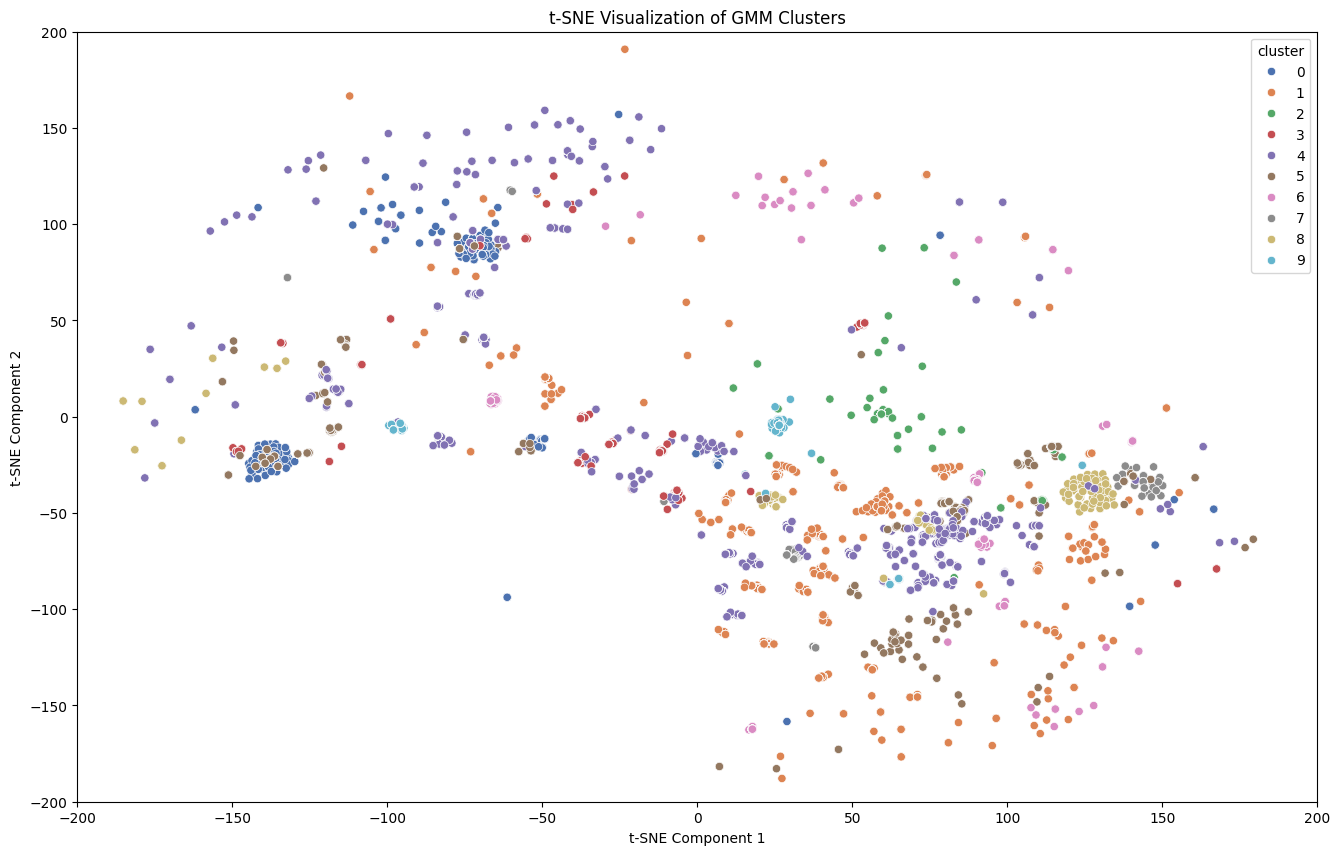

In [40]:
plt.figure(figsize=(16, 10))
sns.scatterplot(data=df_gmm_tsne, x='x1', y='x2', hue='cluster', legend="full", palette='deep')
plt.title('t-SNE Visualization of GMM Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.xlim(-200, 200)  # Zoom in on x-axis
plt.ylim(-200, 200)  # Zoom in on y-axis
plt.show()